# Initial tritium, $^3\!$He, $^4\!$He and Ne fields for CESM's tritium-3He module
Created by Ivan Lima on Mon, 17 Oct 2016 09:55:00 -0400

 **Initial tritium, He and Ne fields for CESM's tritium-3He module (tr3he) using the Liang 2013 gas flux model.**

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings, datetime
from scipy.optimize import curve_fit
from tr3he import *
from cesm_utils import *
from mpl_utils import center_cmap
%matplotlib notebook

In [2]:
warnings.filterwarnings('ignore')
proj = ccrs.Robinson(central_longitude=180+30)

## Read initial temperature, salinity and $u_*$ and SLP climatologies

The climatologies for $u_*^{1.06}$, $u_*^{2.76}$ and $u_*^{3.86}$ were obtained by calculating $u_*$ from 6-hour NCEP $u_{10}$ and $v_{10}$ fields for Jan 1948 to Dec 2007, computing $u_*^{1.06}$, $u_*^{2.76}$ and $u_*^{3.86}$ and then averaging those fields in time.

In [3]:
ds = xr.open_dataset('/home/ivan/Data/Tritium-3H/data/ustar_slp_1948-2007_mean.nc')
for vname in ['TEMP','SALT','PDEN','slp','u10','ustar','ustar_1p06','ustar_2p76','ustar_3p86']:
    print('%12s: %-24s %-11s %23s'%(vname, ds[vname].long_name, ds[vname].units, ds[vname].dims))

        TEMP: potential temperature    deg C       ('z_t', 'nlat', 'nlon')
        SALT: salinity                 g/kg        ('z_t', 'nlat', 'nlon')
        PDEN: potential density        kg/m^3      ('z_t', 'nlat', 'nlon')
         slp: sea level pressure       Pa                 ('nlat', 'nlon')
         u10: wind velocity at 10 m    m/s                ('nlat', 'nlon')
       ustar: friction velocity        m/s                ('nlat', 'nlon')
  ustar_1p06: friction velocity power  (m/s)^1.06         ('nlat', 'nlon')
  ustar_2p76: friction velocity power  (m/s)^2.76         ('nlat', 'nlon')
  ustar_3p86: friction velocity power  (m/s)^3.86         ('nlat', 'nlon')


Fill in region with nans around North Pole created by interpolation of NCEP fields .

In [4]:
i1, i2 = 365, 371
j1, j2 = 151, 169
ds.slp[i1:i2,j1:j2]        = ds.slp[i1+1:i2+1,j1+1:j2+1].mean()
ds.u10[i1:i2,j1:j2]        = ds.u10[i1+1:i2+1,j1+1:j2+1].mean()
ds.ustar[i1:i2,j1:j2]      = ds.ustar[i1+1:i2+1,j1+1:j2+1].mean()
ds.ustar_1p06[i1:i2,j1:j2] = ds.ustar_1p06[i1+1:i2+1,j1+1:j2+1].mean()
ds.ustar_2p76[i1:i2,j1:j2] = ds.ustar_2p76[i1+1:i2+1,j1+1:j2+1].mean()
ds.ustar_3p86[i1:i2,j1:j2] = ds.ustar_3p86[i1+1:i2+1,j1+1:j2+1].mean()

### Maps of input fields

<IPython.core.display.Javascript object>


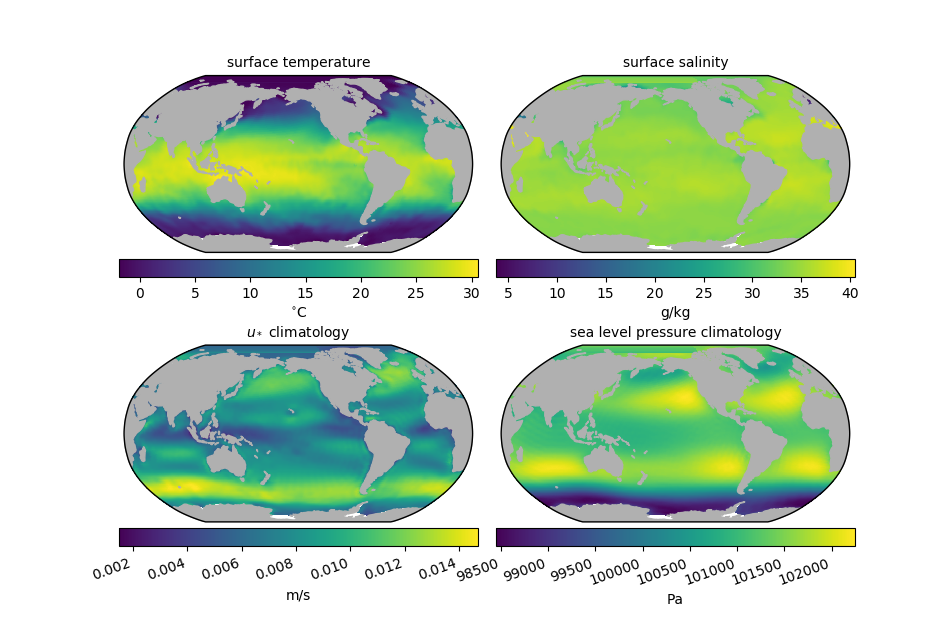

In [5]:
# make coordinates cyclic for plotting
tlat, tlon = ds.TLAT.values, ds.TLONG.values
tlonc = np.concatenate((tlon,tlon[:,0,np.newaxis]),axis=-1)
tlatc = np.concatenate((tlat,tlat[:,0,np.newaxis]),axis=-1)
loncp = np.where(np.greater_equal(tlon,tlon[:,0].min()),tlon-360,tlon) # lon for contour plots (monotonic)

fig, axs = plt.subplots(nrows=2,ncols=2,subplot_kw={'projection':proj},figsize=(9.5,6.3))
fig.subplots_adjust(wspace=0.05,hspace=0.25)
axs = axs.ravel()
for ax in axs:
    ax.set_global()
    ax.add_feature(cfeature.LAND,facecolor='#b0b0b0')
    
pm = axs[0].pcolormesh(tlonc,tlatc,da2ma(ds.TEMP[0,...]),transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.03)
cb.set_label(r'$^{\circ}$C')
axs[0].set_title('surface temperature',fontsize=10)

pm = axs[1].pcolormesh(tlonc,tlatc,da2ma(ds.SALT[0,...]),transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.03)
cb.set_label(r'g/kg')
axs[1].set_title('surface salinity',fontsize=10)

pm = axs[2].pcolormesh(tlonc,tlatc,da2ma(ds.ustar),transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[2],orientation='horizontal',pad=0.03)
cb.ax.set_xticklabels(cb.ax.get_xticklabels(),rotation=20,horizontalalignment='right')
cb.set_label(r'm/s')
axs[2].set_title('$u_*$ climatology',fontsize=10)

pm = axs[3].pcolormesh(tlonc,tlatc,da2ma(ds.slp),transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[3],orientation='horizontal',pad=0.03)
cb.ax.set_xticklabels(cb.ax.get_xticklabels(),rotation=20,horizontalalignment='right')
cb.set_label(r'Pa')
axs[3].set_title('sea level pressure climatology',fontsize=10)

## $^4\!$He, $^3\!$He and Ne equilibrium concentrations

The $^4\!$He, $^3\!$He & Ne equilibrium concentrations (mol m$^{-3}$) at standard atmospheric pressure are given by:

$$ \textrm{$^4\!$He}: C_{eq_{He}} = S\,P_{atm}\,X_{He} $$

$$ \textrm{$^3\!$He}: C_{eq} = C_{eq_{He}}\,I_r\,\alpha_S $$

$$ \textrm{Ne}: C_{eq_{Ne}} = S\,P_{atm}\,X_{Ne} $$

$S$ = gas solubility (mol m$^{-3}$ Pa$^{-1}$), $P_{atm}$ = standard atmospheric pressure (101325 Pa), $X_{He}$ = $^4\!$He atmospheric mole fraction, $X_{Ne}$ = Ne atmospheric mole fraction, $I_r$ = $^3\!$He/$^4\!$He isotopic ratio and $\alpha_S$ = temperature-dependent solubility fractionation factor.

In [6]:
he4_sol = comp_henry_he_sol_0(ds.TEMP,ds.SALT)
ne_sol  = comp_ne_sol_0(ds.TEMP,ds.SALT)
alpha_sol = alpha_sol_he(ds.TEMP)
he4_ceq = he4_sol * Xhe * Patm       # 4He equilibrium concentration
he3_ceq = he4_ceq * Ir  * alpha_sol  # 3He equilibrium concentration
ne_ceq  = ne_sol  * Xne * Patm       # Ne equilibrium concentration
he4_ceq.attrs = {'long_name':'helium 4 equilibriun concentration','units':'mol/m^3'}
he3_ceq.attrs = {'long_name':'helium 3 equilibriun concentration','units':'mol/m^3'}
ne_ceq.attrs  = {'long_name':'neon equilibriun concentration','units':'mol/m^3'}

### Maps of surface $^4\!$He, $^3\!$He and Ne equilibrium concentrations

<IPython.core.display.Javascript object>


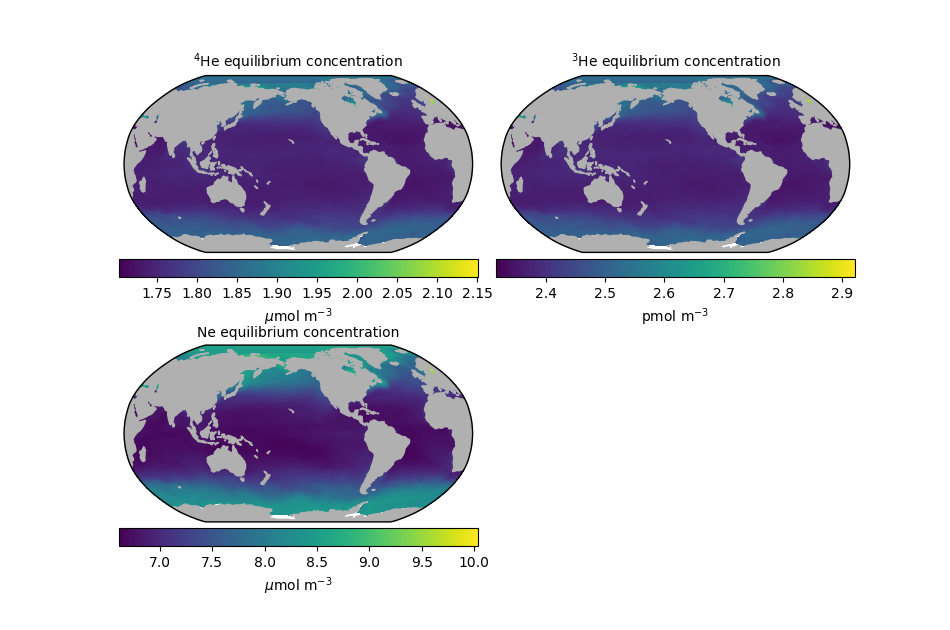

In [7]:
fig, axs = plt.subplots(nrows=2,ncols=2,subplot_kw={'projection':proj},figsize=(9.5,6.3))
fig.subplots_adjust(wspace=0.05,hspace=0.25)
axs = axs.ravel()
fig.delaxes(axs[-1])
for ax in axs:
    ax.set_global()
    ax.add_feature(cfeature.LAND,facecolor='#b0b0b0')

data = da2ma(he4_ceq[0,...]) * 1.e+6 # mol/m^3 -> umol/m^3
pm = axs[0].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree())
axs[0].set_title(r'$^4$He equilibrium concentration',fontsize=10)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.03)
cb.set_label(r'$\mu$mol m$^{-3}$')

data = da2ma(he3_ceq[0,...]) * 1.e+12 # mol/m^3 -> pmol/m^3
pm = axs[1].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree())
axs[1].set_title(r'$^3$He equilibrium concentration',fontsize=10)
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.03)
cb.set_label(r'pmol m$^{-3}$')

data = da2ma(ne_ceq[0,...]) * 1.e+6 # mol/m^3 -> umol/m^3
pm = axs[2].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree())
axs[2].set_title(r'Ne equilibrium concentration',fontsize=10)
cb = fig.colorbar(pm,ax=axs[2],orientation='horizontal',pad=0.03)
cb.set_label(r'$\mu$mol m$^{-3}$')

## Balanced gas fluxes

The equilibrium supersaturation (fraction) at which bubble fluxes are balanced by the diffusive gas exchange is given by:

$$ \Delta_{eq} = \frac{K_b C_{eq} \Delta_P \frac{P_{slp}}{P_{atm}} + F_C}{(K_b + K_s) C_{eq} \frac{P_{slp}}{P_{atm}}} $$

$K_b$ is the gas transfer velocity through large bubbles in m s$^{-1}$:

$$ K_b = 1.98 \times 10^6\, u_*^{2.76} \left(\frac{S_C}{660}\right)^{-\frac{2}{3}} \left[\frac{\textrm{cm}}{\textrm{hr}}\right] \times \frac{1}{360000} \left[\frac{\textrm{m}}{\textrm{cm}} \frac{\textrm{hr}}{s}\right] $$

$\Delta_P$ is the supersaturation (fraction) due to partially dissolved bubbles:

$$ \Delta_P = \frac{152.44}{100}\,u_*^{1.06} $$ 

$F_C$ is the flux due to completely dissolved bubbles in mol m$^{-2}$ s$^{-1}$:

$$ F_C = 5.56\,u_*^{3.86}\,X_{gas} $$

$K_s$ is the gas transfer velocity for diffusive gas exchange:

$$ K_s = \frac{u_*}{r_{wt} + \alpha\,r_{at}} $$

$r_{wt}$ and $r_{at}$ are the water-side and air-side resistance to transfer, respectively:

$$ r_{wt} = \sqrt{\frac{\rho_w}{\rho_a}} \left(h_w \sqrt{S_{C}} + \frac{1}{\kappa}\,\ln{\frac{z_w}{\delta_w}}\right)$$
$$ r_{at} = h_a \sqrt{S_{C_a}} + \frac{1}{\sqrt{c_d}} - 5 + \frac{\ln{S_{C_a}}}{2\kappa} $$

$\alpha$ is the dimensioless solubility:

$$ \alpha = C_{eq}\,P_{atm}\,R\,T $$

$S_C$ = Schmidt number of gas, $S_{C_a}$ = Schmidt number of air (0.9), $z_w$ = reference water depth (0.5), $\delta_w$ = molecular sublayer thickness (0.01), $\kappa$ = 0.4, $h_a$ = 0.13, $A$ = 1.3, $\phi$ = 1, $h_w = \frac{13.3}{A\,\phi}$, $R$ = ideal gas constant (8.314425 $\frac{\textrm{Pa m}^3}{\textrm{K mol}}$), $c_d$ = drag coefficient, $T$ = potential temperature (Kelvin), $P_{slp}$ = local sea level pressure, $P_{atm}$ = standard atmospheric pressure (101325 Pa), $C_{eq}$ = equilibrium concentration of gas at standard atmospheric pressure.

The gas concentration in the water (mol m$^{-3}$) so that the diffusive gas exchange balances the bubble fluxes is given by:

$$ C^* = \left(1 + \Delta_{eq}\right) C_{eq} $$

## Balanced fluxes for $^3\!$He

In the case of $^3\!$He, the $^4\!$He Schmidt number is scaled by the $^3\!$He/$^4\!$He diffusivity ratio ($\alpha_D$) from Bourg & Sposito (2008):

$$ S_{C_{^3\!He}} = \frac{S_{C_{^3\!He}}}{\alpha_D} $$

And the the flux due to completely dissolved bubbles ($F_C$) is scaled by the $^3\!$He/$^4\!$He isotopic ratio ($I_r$):

$$ F_C = 5.56\,u_*^{3.86}\,X_{He}\,I_r $$

In [8]:
Sca     = 0.9
zw      = 0.5
deltaw  = 0.01
kappa   = 0.4
ha      = 0.13
A       = 1.3
phi     = 1
hw      = 13.3 / (A * phi)
sst     = ds.TEMP[0,...]
rhow    = ds.PDEN[0,...]
Ceq_he3 = he3_ceq[0,...]

In [9]:
Sc     = comp_schmidt_sw(sst,'He') / alpha_diff                       # scale 4He Sc number by 3He/4He diffusivity ratio
Kb     = 1.98e+6 * ds.ustar_2p76 * np.power(Sc/660,-2/3) * 1.e-2/3600 # cm/hr -> m/s
deltaP = 152.55  * ds.ustar_1p06 / 100                                # % -> fraction
Fc     = 5.56    * ds.ustar_3p86 * Xhe * Ir
cd     = calc_cd10(ds.ustar)
rw     = np.sqrt(rhow/rhoair) * (hw * np.sqrt(Sc) + np.log(zw/deltaw)/kappa)
ra     = ha * np.sqrt(Sca) + 1/np.sqrt(cd) - 5 + np.log(Sca)/(2*kappa)
alpha  = Ceq_he3 * Patm * R * (sst + T0K)
Ks     = ds.ustar / (rw + alpha * ra)

delta_eq_he3 = (Kb * Ceq_he3 * deltaP * ds.slp/Patm + Fc) / ((Kb + Ks) * Ceq_he3 * ds.slp/Patm)
Cstar_he3 = (1 + delta_eq_he3) * Ceq_he3

### Plot maps

<IPython.core.display.Javascript object>


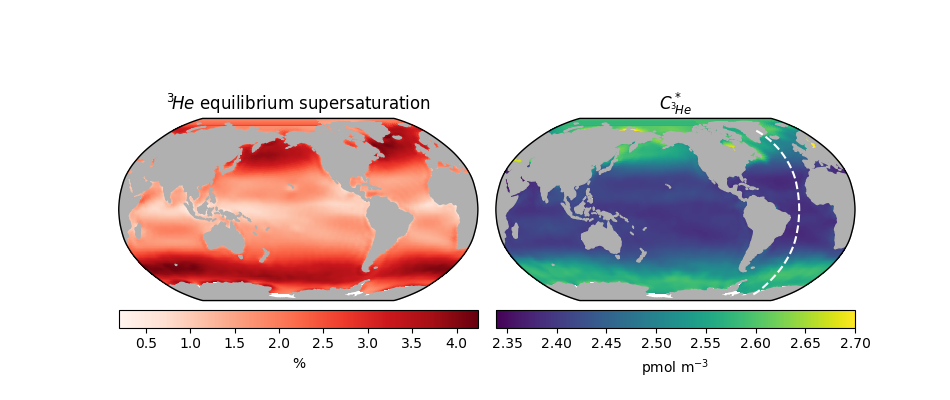

In [10]:
jj = 12
fig, axs = plt.subplots(ncols=2,subplot_kw={'projection':proj},figsize=(9.5,4))
fig.subplots_adjust(wspace=0.05)
axs =axs.ravel()

axs[0].set_global()
axs[0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = da2ma(delta_eq_he3) * 100 # fraction -> %
pm = axs[0].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.03)
cb.set_label(r'%')
axs[0].set_title(r'$^3\!He$ equilibrium supersaturation')

axs[1].set_global()
axs[1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = da2ma(Cstar_he3) * 1.e+12 # mol/m^3 -> pmol/m^3
pm = axs[1].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),vmax=2.7)
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.03)
cb.set_label(r'pmol m$^{-3}$')
axs[1].set_title(r'$C^*_{^3\!He}$')
l1 = axs[1].plot(tlon[:,jj],tlat[:,jj],'w--',transform=ccrs.Geodetic())

### $C^*_{^3\!He}$ as function of temperature

Fit quadratic curve to temperature, $C^*$ relationship. Marginal Seas produce outliers.

In [11]:
rmask = ds.REGION_MASK.values
temp  = da2ma(sst)
cs    = da2ma(Cstar_he3)
cs = np.ma.masked_where(rmask<0,  cs)  # remove marginal seas
cs = np.ma.masked_where(rmask==7, cs)  # remove Mediterranean Sea
cs = np.ma.masked_where(rmask==4, cs)  # remove Persian Gulf
# cs = np.ma.masked_where(rmask==11,cs)  # remove Hudson Bay
# cs = np.ma.masked_where(rmask==10,cs)  # remove Arctic

mask = cs.mask | temp.mask                                        # compute common mask
cs, temp = np.ma.array(cs,mask=mask), np.ma.array(temp,mask=mask) # apply common mask
cs, temp = cs.ravel().compressed(), temp.ravel().compressed()

# quadratic function to fit
def func(x,a,b,c):
    return a * x**2 + b * x + c

# fit curve
popt, pcov = curve_fit(func,temp,cs)

#### Plot data & fit 

<IPython.core.display.Javascript object>


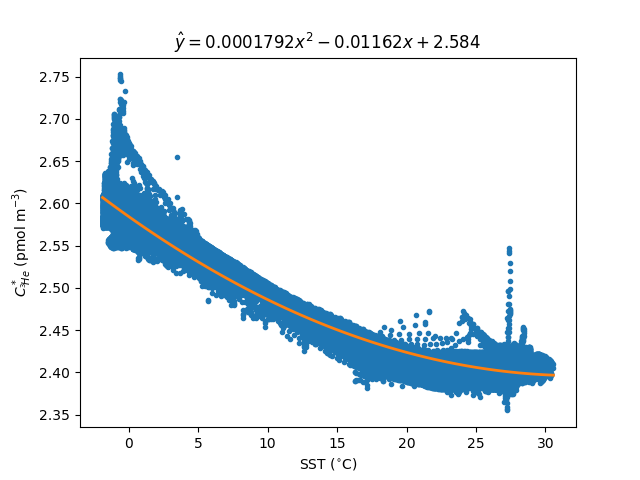

In [12]:
t = np.linspace(temp.min(),temp.max(),100)
cs_pred = func(t,*popt)

fig, ax = plt.subplots()
p1, = ax.plot(temp,cs*1.e+12,'.')
p2, = ax.plot(t,cs_pred*1.e+12,'-',linewidth=2)
a, b, c = popt*1.e+12
title = r'$\hat{y} = %.4g x^2 %+.4g x  %+.4g$'%(a,b,c)
_ = ax.set(xlabel=r'SST ($^{\circ}$C)',ylabel=r'$C^*_{^3\!He}$ (pmol m$^{-3}$)',title=title)
#ax.grid(True)

### Set $C^*_{^3\!He}$ at ocean interior use fitted curve

In [13]:
Cstar_he3_3D = func(ds.TEMP,*popt)
#Cstar_he3_3D[0,...] = Cstar_he3
Cstar_he3_3D.name   = 'HELIUM3'
Cstar_he3_3D.attrs  = {'long_name':'helium 3', 'units':'mol/m^3'}

#### Sections along 26.5 $^{\circ}$W

<IPython.core.display.Javascript object>


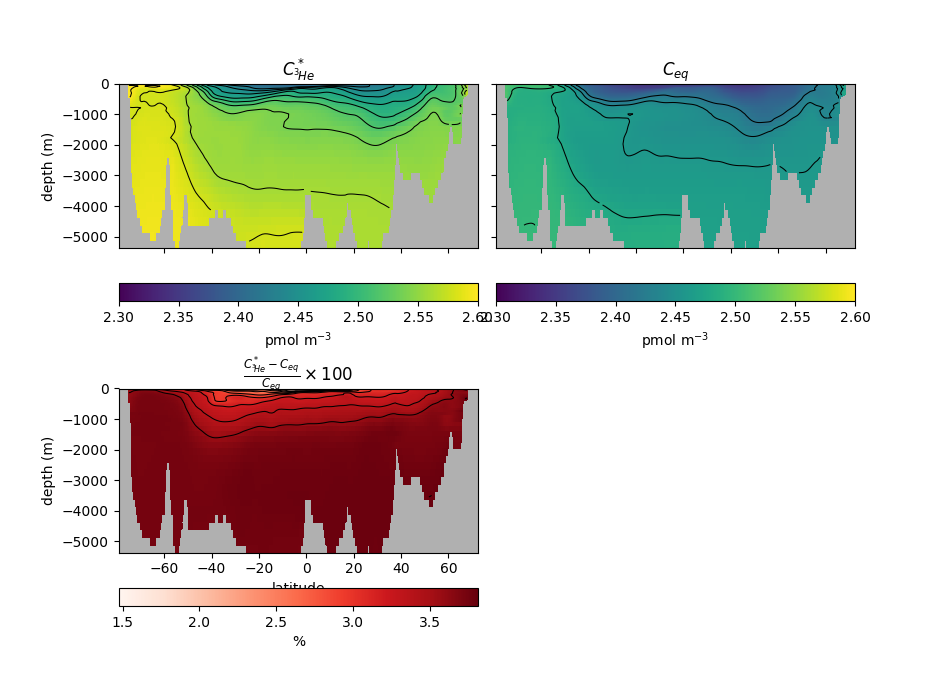

In [14]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(9.5,7))
fig.subplots_adjust(wspace=0.05,hspace=0.3)
axs = axs.ravel()
fig.delaxes(axs[-1])
zt = ds.z_t.values / 100 # cm -> m
vmin, vmax = 2.3, 2.6

data1 = da2ma(Cstar_he3_3D.isel(nlon=jj)) * 1.e+12 # mol/m^3 -> pmol/m^3 
pm = axs[0].pcolormesh(tlat[:,jj],-zt,data1,vmin=vmin,vmax=vmax)
cs = axs[0].contour(tlat[:,jj],-zt,data1,12,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal')
cb.set_label(r'pmol m$^{-3}$')
axs[0].set(ylabel='depth (m)',title=r'$C^*_{^3\!He}$')
axs[0].set_axis_bgcolor('#b0b0b0')
clev = cs.levels
#print(pm.get_clim())

data2 = da2ma(he3_ceq.isel(nlon=jj)) * 1.e+12 # mol/m^3 -> pmol/m^3
pm = axs[1].pcolormesh(tlat[:,jj],-zt,data2,vmin=vmin,vmax=vmax)
cs = axs[1].contour(tlat[:,jj],-zt,data2,clev,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal')
cb.set_label(r'pmol m$^{-3}$')
axs[1].set(title=r'$C_{eq}$')
axs[1].set_axis_bgcolor('#b0b0b0')
#print(pm.get_clim())

supsat = (data1-data2)/data2 * 100
pm = axs[2].pcolormesh(tlat[:,jj],-zt,supsat,cmap=plt.cm.Reds)
#center_cmap(pm)
cs = axs[2].contour(tlat[:,jj],-zt,supsat,12,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[2],orientation='horizontal')
cb.set_label(r'%')
axs[2].set(title=r'$\frac{C^*_{^3\!He} - C_{eq}}{C_{eq}} \times 100$',xlabel='latitude',ylabel='depth (m)')
axs[2].set_axis_bgcolor('#b0b0b0')
#print(pm.get_clim())

### $K_s$ & $K_b$ as function of wind speed ($u_{10}$)

<IPython.core.display.Javascript object>


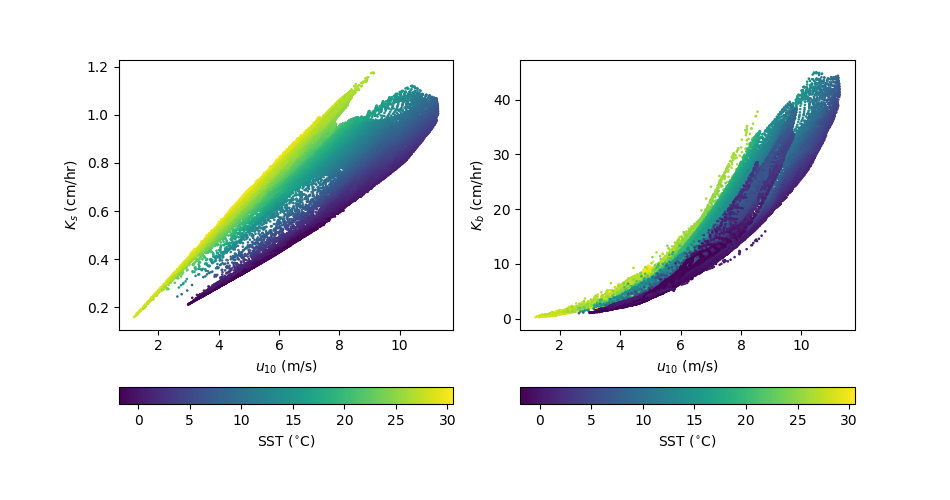

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(9.5,5))
sp = ax1.scatter(ds.u10.values.ravel(),Ks.values.ravel()*360000,3,c=sst,marker='.') # m/s -> cm/hr
cb = fig.colorbar(sp,ax=ax1,orientation='horizontal')
_ = cb.set_label(r'SST ($^{\circ}$C)')
_ = ax1.set(xlabel=r'$u_{10}$ (m/s)',ylabel=r'$K_s$ (cm/hr)')
sp = ax2.scatter(ds.u10.values.ravel(),Kb.values.ravel()*360000,3,c=sst,marker='.') # m/s -> cm/hr
cb = fig.colorbar(sp,ax=ax2,orientation='horizontal')
_ = cb.set_label(r'SST ($^{\circ}$C)')
_ = ax2.set(xlabel=r'$u_{10}$ (m/s)',ylabel=r'$K_b$ (cm/hr)')

## Balanced fluxes for $^4\!$He

In [16]:
Ceq_he4 = he4_ceq[0,...]
Sc      = comp_schmidt_sw(sst,'He')
Kb      = 1.98e+6 * ds.ustar_2p76 * np.power(Sc/660,-2/3) * 1.e-2/3600 # cm/hr -> m/s
deltaP  = 152.55  * ds.ustar_1p06 / 100                                # % -> fraction
Fc      = 5.56    * ds.ustar_3p86 * Xhe
cd      = calc_cd10(ds.ustar)
rw      = np.sqrt(rhow/rhoair) * (hw * np.sqrt(Sc) + np.log(zw/deltaw)/kappa)
ra      = ha * np.sqrt(Sca) + 1/np.sqrt(cd) - 5 + np.log(Sca)/(2*kappa)
alpha   = Ceq_he3 * Patm * R * (sst + T0K)
Ks      = ds.ustar / (rw + alpha * ra)

delta_eq_he4 = (Kb * Ceq_he4 * deltaP * ds.slp/Patm + Fc) / ((Kb + Ks) * Ceq_he4 * ds.slp/Patm)
Cstar_he4 = (1 + delta_eq_he4) * Ceq_he4

### Plot maps

<IPython.core.display.Javascript object>


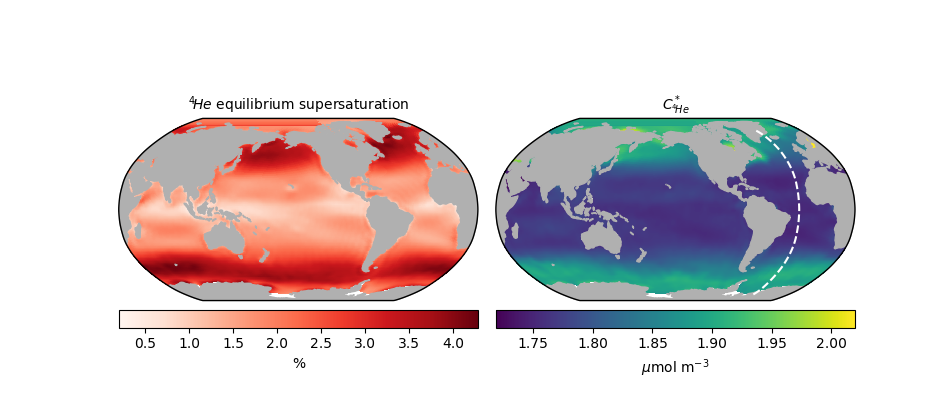

In [17]:
jj = 12
fig, axs = plt.subplots(ncols=2,subplot_kw={'projection':proj},figsize=(9.5,4))
fig.subplots_adjust(wspace=0.05)
axs =axs.ravel()

axs[0].set_global()
axs[0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = da2ma(delta_eq_he4) * 100 # fraction -> %
pm = axs[0].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.03)
cb.set_label(r'%')
axs[0].set_title(r'$^4\!He$ equilibrium supersaturation',fontsize=10)

axs[1].set_global()
axs[1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = da2ma(Cstar_he4) * 1.e+6 # mol/m^3 -> mumol/m^3
pm = axs[1].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),vmax=2.02)
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.03)
cb.set_label(r'$\mu$mol m$^{-3}$')
axs[1].set_title(r'$C^*_{^4\!He}$',fontsize=10)
l1 = axs[1].plot(tlon[:,jj],tlat[:,jj],'w--',transform=ccrs.Geodetic())

### $C^*_{^4\!He}$ as function of temperature

Fit quadratic curve to temperature, $C^*$ relationship. Marginal Seas produce outliers.

In [18]:
temp = da2ma(sst)
cs   = da2ma(Cstar_he4)
cs = np.ma.masked_where(rmask<0,  cs)  # remove marginal seas
cs = np.ma.masked_where(rmask==7, cs)  # remove Mediterranean Sea
cs = np.ma.masked_where(rmask==4, cs)  # remove Persian Gulf

mask = cs.mask | temp.mask                                        # compute common mask
cs, temp = np.ma.array(cs,mask=mask), np.ma.array(temp,mask=mask) # apply common mask
cs, temp = cs.ravel().compressed(), temp.ravel().compressed()

# fit curve
popt, pcov = curve_fit(func,temp,cs)

#### Plot data & fit 

<IPython.core.display.Javascript object>


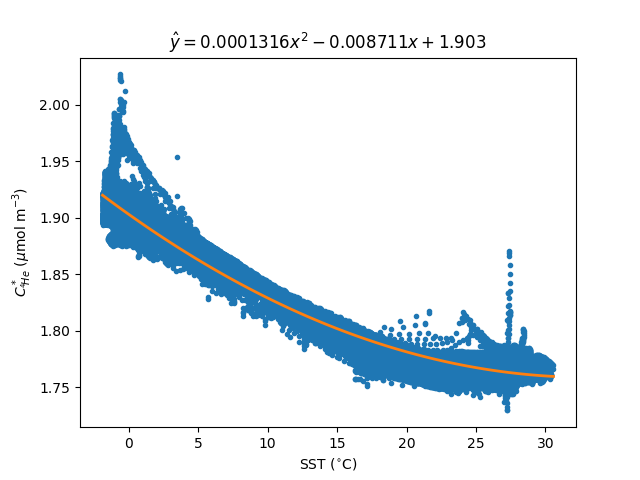

In [19]:
t = np.linspace(temp.min(),temp.max(),100)
cs_pred = func(t,*popt)

fig, ax = plt.subplots()
p1, = ax.plot(temp,cs*1.e+6,'.')
p2, = ax.plot(t,cs_pred*1.e+6,'-',linewidth=2)
a, b, c = popt*1.e+6
title = r'$\hat{y} = %.4g x^2 %+.4g x  %+.4g$'%(a,b,c)
_ = ax.set(xlabel=r'SST ($^{\circ}$C)',ylabel=r'$C^*_{^4\!He}$ ($\mu$mol m$^{-3}$)',title=title)
#ax.grid(True)

### Set $C^*_{^4\!He}$ at ocean interior use fitted curve

In [20]:
Cstar_he4_3D = func(ds.TEMP,*popt)
#Cstar_he4_3D[0,...] = Cstar_he4
Cstar_he4_3D.name   = 'HELIUM4'
Cstar_he4_3D.attrs  = {'long_name':'helium 4', 'units':'mol/m^3'}

#### Sections along 26.5 $^{\circ}$W

<IPython.core.display.Javascript object>


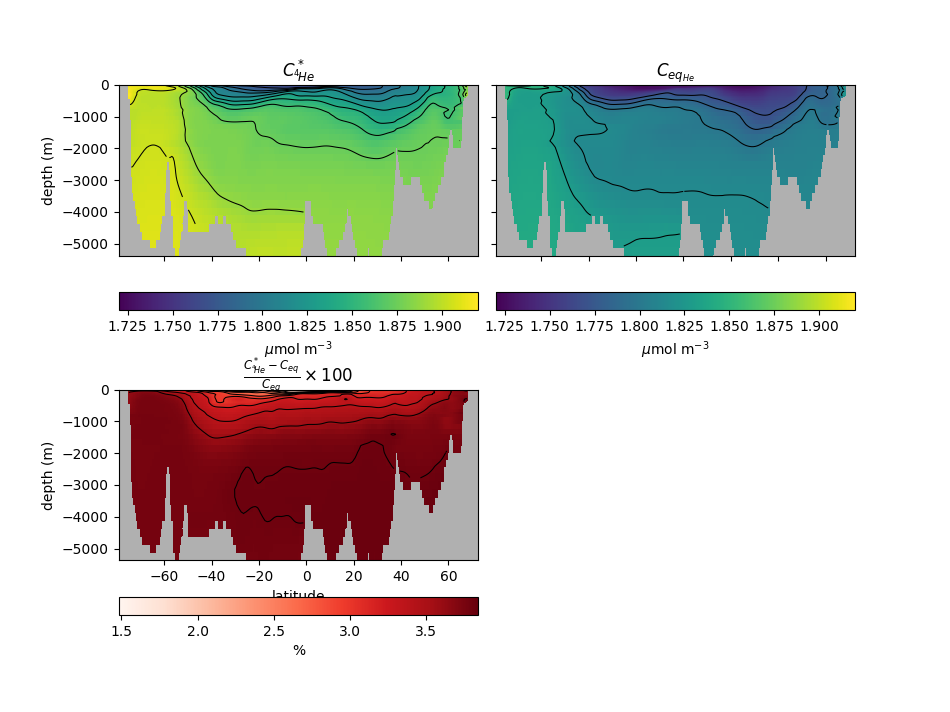

In [21]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(9.5,7.125))
fig.subplots_adjust(wspace=0.05,hspace=0.25)
axs = axs.ravel()
fig.delaxes(axs[-1])
zt = ds.z_t.values / 100 # cm -> m
vmin, vmax = 1.72, 1.92
#vmin, vmax = None, None

data1 = da2ma(Cstar_he4_3D.isel(nlon=jj)) * 1.e+6 # mol/m^3 -> mumol/m^3 
pm = axs[0].pcolormesh(tlat[:,jj],-zt,data1,vmin=vmin,vmax=vmax)
cs = axs[0].contour(tlat[:,jj],-zt,data1,12,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal')
cb.set_label(r'$\mu$mol m$^{-3}$')
axs[0].set(ylabel='depth (m)',title=r'$C^*_{^4\!He}$')
axs[0].set_axis_bgcolor('#b0b0b0')
clev = cs.levels
#print(pm.get_clim())

data2 = da2ma(he4_ceq.isel(nlon=jj)) * 1.e+6 # mol/m^3 -> mumol/m^3
pm = axs[1].pcolormesh(tlat[:,jj],-zt,data2,vmin=vmin,vmax=vmax)
cs = axs[1].contour(tlat[:,jj],-zt,data2,clev,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal')
cb.set_label(r'$\mu$mol m$^{-3}$')
axs[1].set(title=r'$C_{eq_{He}}$')
axs[1].set_axis_bgcolor('#b0b0b0')
#print(pm.get_clim())

supsat = (data1-data2)/data2 * 100
pm = axs[2].pcolormesh(tlat[:,jj],-zt,supsat,cmap=plt.cm.Reds)
#center_cmap(pm)
cs = axs[2].contour(tlat[:,jj],-zt,supsat,12,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[2],orientation='horizontal')
cb.set_label(r'%')
axs[2].set(title=r'$\frac{C^*_{^4\!He} - C_{eq}}{C_{eq}} \times 100$',xlabel='latitude',ylabel='depth (m)')
axs[2].set_axis_bgcolor('#b0b0b0')
#print(pm.get_clim())

### $K_s$ & $K_b$ as function of wind speed ($u_{10}$)

<IPython.core.display.Javascript object>


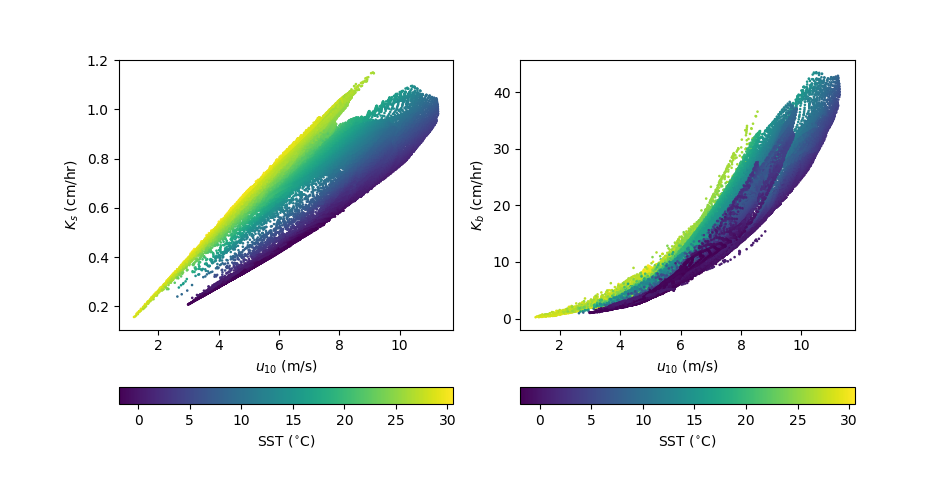

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(9.5,5))
sp = ax1.scatter(ds.u10.values.ravel(),Ks.values.ravel()*360000,3,c=sst,marker='.') # m/s -> cm/hr
cb = fig.colorbar(sp,ax=ax1,orientation='horizontal')
_ = cb.set_label(r'SST ($^{\circ}$C)')
_ = ax1.set(xlabel=r'$u_{10}$ (m/s)',ylabel=r'$K_s$ (cm/hr)')
sp = ax2.scatter(ds.u10.values.ravel(),Kb.values.ravel()*360000,3,c=sst,marker='.') # m/s -> cm/hr
cb = fig.colorbar(sp,ax=ax2,orientation='horizontal')
_ = cb.set_label(r'SST ($^{\circ}$C)')
_ = ax2.set(xlabel=r'$u_{10}$ (m/s)',ylabel=r'$K_b$ (cm/hr)')

## Balanced fluxes for Ne

In [23]:
Ceq_ne  = ne_ceq[0,...]
Sc      = comp_schmidt_sw(sst,'Ne')
Kb      = 1.98e+6 * ds.ustar_2p76 * np.power(Sc/660,-2/3) * 1.e-2/3600 # cm/hr -> m/s
deltaP  = 152.55  * ds.ustar_1p06 / 100                                # % -> fraction
Fc      = 5.56    * ds.ustar_3p86 * Xne
cd      = calc_cd10(ds.ustar)
rw      = np.sqrt(rhow/rhoair) * (hw * np.sqrt(Sc) + np.log(zw/deltaw)/kappa)
ra      = ha * np.sqrt(Sca) + 1/np.sqrt(cd) - 5 + np.log(Sca)/(2*kappa)
alpha   = Ceq_ne * Patm * R * (sst + T0K)
Ks      = ds.ustar / (rw + alpha * ra)

delta_eq_ne = (Kb * Ceq_ne * deltaP * ds.slp/Patm + Fc) / ((Kb + Ks) * Ceq_ne * ds.slp/Patm)
Cstar_ne = (1 + delta_eq_ne) * Ceq_ne

### Plot maps

<IPython.core.display.Javascript object>


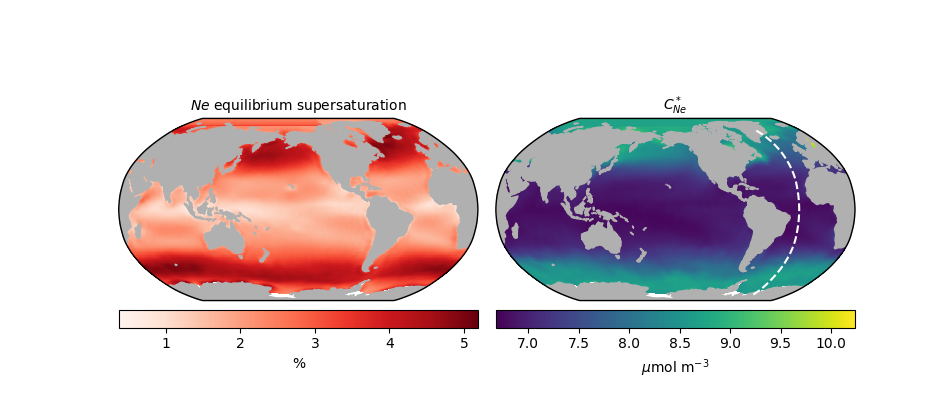

In [24]:
jj = 12
fig, axs = plt.subplots(ncols=2,subplot_kw={'projection':proj},figsize=(9.5,4))
fig.subplots_adjust(wspace=0.05)
axs =axs.ravel()

axs[0].set_global()
axs[0].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = da2ma(delta_eq_ne) * 100 # fraction -> %
pm = axs[0].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree(),cmap=plt.cm.Reds)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.03)
cb.set_label(r'%')
axs[0].set_title(r'$Ne$ equilibrium supersaturation',fontsize=10)

axs[1].set_global()
axs[1].add_feature(cfeature.LAND,facecolor='#b0b0b0')
data = da2ma(Cstar_ne) * 1.e+6 # mol/m^3 -> mumol/m^3
pm = axs[1].pcolormesh(tlonc,tlatc,data,transform=ccrs.PlateCarree())
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.03)
cb.set_label(r'$\mu$mol m$^{-3}$')
axs[1].set_title(r'$C^*_{Ne}$',fontsize=10)
l1 = axs[1].plot(tlon[:,jj],tlat[:,jj],'w--',transform=ccrs.Geodetic())

### $C^*_{Ne}$ as function of temperature

Fit quadratic curve to temperature, $C^*$ relationship. Marginal Seas produce outliers.

In [25]:
temp = da2ma(sst)
cs   = da2ma(Cstar_ne)
cs = np.ma.masked_where(rmask<0,  cs)  # remove marginal seas
cs = np.ma.masked_where(rmask==7, cs)  # remove Mediterranean Sea
cs = np.ma.masked_where(rmask==4, cs)  # remove Persian Gulf

mask = cs.mask | temp.mask                                        # compute common mask
cs, temp = np.ma.array(cs,mask=mask), np.ma.array(temp,mask=mask) # apply common mask
cs, temp = cs.ravel().compressed(), temp.ravel().compressed()

# fit curve
popt, pcov = curve_fit(func,temp,cs)

#### Plot data & fit 

<IPython.core.display.Javascript object>


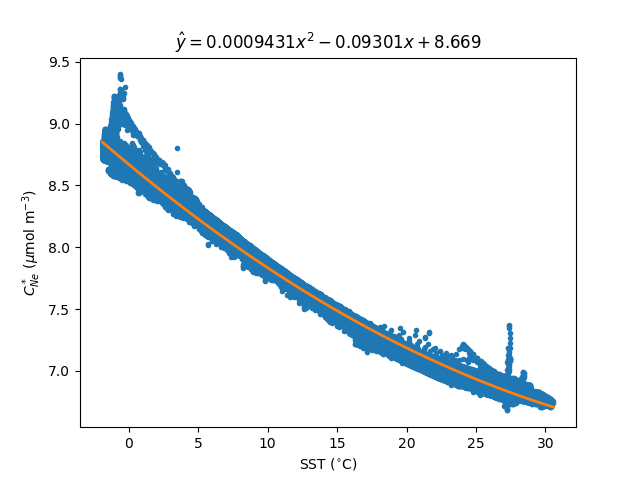

In [26]:
t = np.linspace(temp.min(),temp.max(),100)
cs_pred = func(t,*popt)

fig, ax = plt.subplots()
p1, = ax.plot(temp,cs*1.e+6,'.')
p2, = ax.plot(t,cs_pred*1.e+6,'-',linewidth=2)
a, b, c = popt*1.e+6
title = r'$\hat{y} = %.4g x^2 %+.4g x  %+.4g$'%(a,b,c)
_ = ax.set(xlabel=r'SST ($^{\circ}$C)',ylabel=r'$C^*_{Ne}$ ($\mu$mol m$^{-3}$)',title=title)
#ax.grid(True)

### Set $C^*_{Ne}$ at ocean interior use fitted curve

In [27]:
Cstar_ne_3D = func(ds.TEMP,*popt)
#Cstar_ne_3D[0,...] = Cstar_ne
Cstar_ne_3D.name   = 'NEON'
Cstar_ne_3D.attrs  = {'long_name':'neon', 'units':'mol/m^3'}

#### Sections along 26.5 $^{\circ}$W

<IPython.core.display.Javascript object>


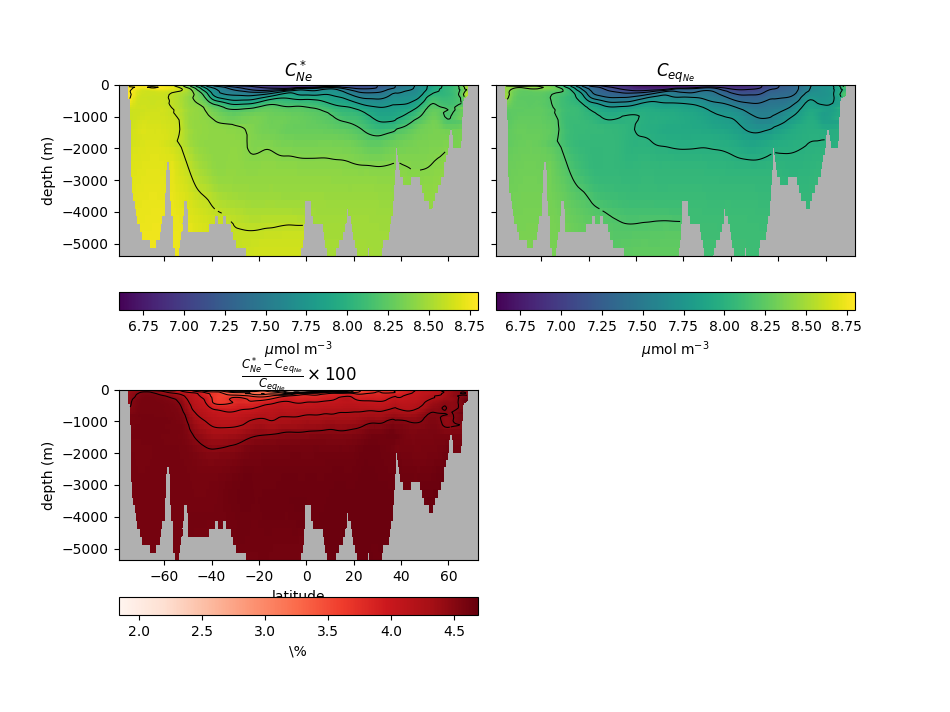

In [28]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(9.5,7.125))
fig.subplots_adjust(wspace=0.05,hspace=0.25)
axs = axs.ravel()
fig.delaxes(axs[-1])
zt = ds.z_t.values / 100 # cm -> m
vmin, vmax = 6.6, 8.8
#vmin, vmax = None, None

data1 = da2ma(Cstar_ne_3D.isel(nlon=jj)) * 1.e+6 # mol/m^3 -> mumol/m^3 
pm = axs[0].pcolormesh(tlat[:,jj],-zt,data1,vmin=vmin,vmax=vmax)
cs = axs[0].contour(tlat[:,jj],-zt,data1,12,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal')
cb.set_label(r'$\mu$mol m$^{-3}$')
axs[0].set(ylabel='depth (m)',title=r'$C^*_{Ne}$')
axs[0].set_axis_bgcolor('#b0b0b0')
clev = cs.levels
#print(pm.get_clim())

data2 = da2ma(ne_ceq.isel(nlon=jj)) * 1.e+6 # mol/m^3 -> mumol/m^3
pm = axs[1].pcolormesh(tlat[:,jj],-zt,data2,vmin=vmin,vmax=vmax)
cs = axs[1].contour(tlat[:,jj],-zt,data2,clev,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal')
cb.set_label(r'$\mu$mol m$^{-3}$')
axs[1].set(title=r'$C_{eq_{Ne}}$')
axs[1].set_axis_bgcolor('#b0b0b0')
#print(pm.get_clim())

supsat = (data1-data2)/data2 * 100
pm = axs[2].pcolormesh(tlat[:,jj],-zt,supsat,cmap=plt.cm.Reds)
#center_cmap(pm)
cs = axs[2].contour(tlat[:,jj],-zt,supsat,12,colors='k',linewidths=0.75)
cb = fig.colorbar(pm,ax=axs[2],orientation='horizontal')
cb.set_label(r'\%')
axs[2].set(title=r'$\frac{C^*_{Ne} - C_{eq_{Ne}}}{C_{eq_{Ne}}} \times 100$',xlabel='latitude',ylabel='depth (m)')
axs[2].set_axis_bgcolor('#b0b0b0')

### $K_s$ & $K_b$ as function of wind speed ($u_{10}$)

<IPython.core.display.Javascript object>


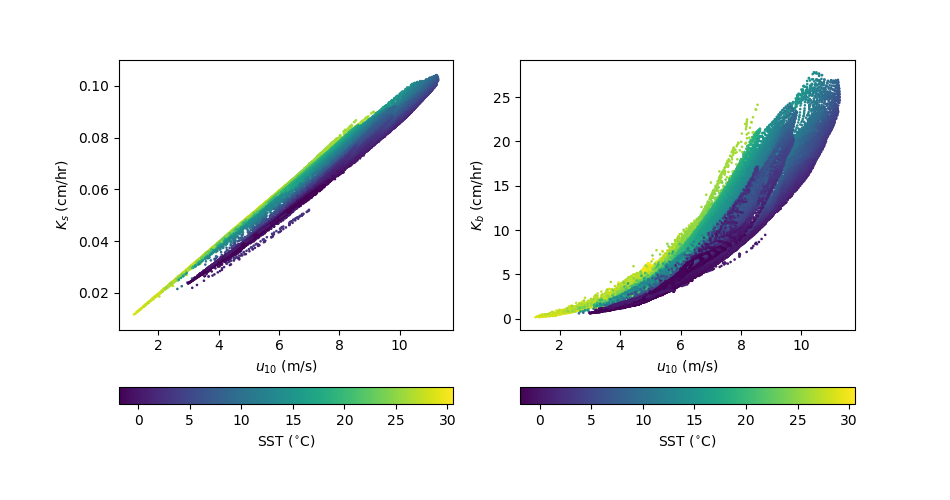

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(9.5,5))
sp = ax1.scatter(ds.u10.values.ravel(),Ks.values.ravel()*360000,3,c=sst,marker='.') # m/s -> cm/hr
cb = fig.colorbar(sp,ax=ax1,orientation='horizontal')
_ = cb.set_label(r'SST ($^{\circ}$C)')
_ = ax1.set(xlabel=r'$u_{10}$ (m/s)',ylabel=r'$K_s$ (cm/hr)')
sp = ax2.scatter(ds.u10.values.ravel(),Kb.values.ravel()*360000,3,c=sst,marker='.') # m/s -> cm/hr
cb = fig.colorbar(sp,ax=ax2,orientation='horizontal')
_ = cb.set_label(r'SST ($^{\circ}$C)')
_ = ax2.set(xlabel=r'$u_{10}$ (m/s)',ylabel=r'$K_b$ (cm/hr)')

## Set initial tritium to zero

In [30]:
tr = np.zeros(Cstar_he3_3D.shape)
tr = np.where(np.isnan(Cstar_he3_3D),np.nan,tr)
tr0_pmol = xr.DataArray(tr,coords=Cstar_he3_3D.coords,name='TRITIUM',attrs={'long_name':'tritium','units':'pmol/m^3'})

## Convert initial $^3\!$He from mol  m$^{-3}$ to pmol m$^{-3}$

In [31]:
Cstar_he3_3D_pmol = Cstar_he3_3D * 1.e+12
Cstar_he3_3D_pmol.name = 'HELIUM3'
Cstar_he3_3D_pmol.attrs = {'long_name':'helium 3', 'units':'pmol/m^3'}

## Convert initial $^4\!$He from mol  m$^{-3}$ to $\mu$mol m$^{-3}$

In [32]:
Cstar_he4_3D_mumol = Cstar_he4_3D * 1.e+6
Cstar_he4_3D_mumol.name = 'HELIUM4'
Cstar_he4_3D_mumol.attrs = {'long_name':'helium 4', 'units':'mumol/m^3'}

## Convert initial Ne from mol  m$^{-3}$ to $\mu$mol m$^{-3}$

In [33]:
Cstar_ne_3D_mumol = Cstar_ne_3D * 1.e+6
Cstar_ne_3D_mumol.name = 'NEON'
Cstar_ne_3D_mumol.attrs = {'long_name':'neon', 'units':'mumol/m^3'}

## Write initial fields to netCDF4

In [34]:
contents = """Initial tritium, 3He, 4He & Ne fields for CESM. 
Tritium is set to zero and helium 3, helium 4 and neon are 
set to Liang's equillibrium super saturation so that the 
diffusive gas exchange balances the gas flux due to bubbles
(Liang et al 2013)."""
history = 'Created by Ivan Lima <ivan@whoi.edu> on %s'%datetime.datetime.now().ctime()
encoding = {'z_t':{'dtype':np.float64}, 'TLONG':{'dtype':np.float32}, 'TLAT':{'dtype':np.float32}, 
            'HELIUM4'      : {'dtype':np.float32, '_FillValue':1.e+20},
            'HELIUM3'      : {'dtype':np.float32, '_FillValue':1.e+20},
            'INERT_HELIUM3': {'dtype':np.float32, '_FillValue':1.e+20},            
            'TRITIUM'      : {'dtype':np.float32, '_FillValue':1.e+20},
            'NEON'         : {'dtype':np.float32, '_FillValue':1.e+20}}
dsout = xr.Dataset({'TRITIUM':tr0_pmol, 'HELIUM3':Cstar_he3_3D_pmol, 'INERT_HELIUM3':Cstar_he3_3D_pmol,
                    'HELIUM4':Cstar_he4_3D_mumol, 'NEON':Cstar_ne_3D_mumol},
                   attrs={'contents':contents, 'history':history})
dsout.merge(ds[['KMT']], inplace=True)
# #outfile = '/bali/data/ilima/cesm/cesm1_input/ocn/pop/gx1v6/ic/tritium_3He_init_Liang.nc'
# outfile = '/bali/data/ilima/cesm/cesm1_input/ocn/pop/gx1v6/ic/test_tritium_3He_init_Liang.nc'
# dsout.to_netcdf(outfile,format='NETCDF3_CLASSIC',encoding=encoding)

<xarray.Dataset>
Dimensions:        (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLONG          (nlat, nlon) float64 320.6 321.7 322.8 323.9 325.1 326.2 ...
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 -79.22 ...
  * z_t            (z_t) float32 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    TRITIUM        (z_t, nlat, nlon) float64 nan nan nan nan nan nan nan nan ...
    HELIUM3        (z_t, nlat, nlon) float64 nan nan nan nan nan nan nan nan ...
    INERT_HELIUM3  (z_t, nlat, nlon) float64 nan nan nan nan nan nan nan nan ...
    HELIUM4        (z_t, nlat, nlon) float64 nan nan nan nan nan nan nan nan ...
    NEON           (z_t, nlat, nlon) float64 nan nan nan nan nan nan nan nan ...
    KMT            (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    contents:  Initial tritium, 3He, 4He & Ne fields for CESM. \nTritium is s...
    history:   Created by Ivan Lima <ivan@who